# **Topic Modeling With LDA**

In [3]:
import pickle
import pandas as pd
import pyLDAvis.gensim
from gensim import corpora
import gensim

# Save Topic Models and Visualizations and DF

# with open('topic_models.pkl', 'wb') as f:
    # pickle.dump(model, f)

# with open('topic_models_vis.pkl', 'wb') as f:
    # pickle.dump(display, f)

# with open('DataFrame.pkl', 'wb') as f:
    # pickle.dump(df, f)


# Load Topic Models and Visualizations and DF
with open('topic_models.pkl', 'rb') as f:
    model = pickle.load(f)

with open('topic_models_vis.pkl', 'rb') as f:
    display = pickle.load(f)

# with open('DataFrame.pkl', 'rb') as f:
#     df = pickle.load(f)


/home/viswaas/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


EOFError: Ran out of input

## Word Cloud Visualization

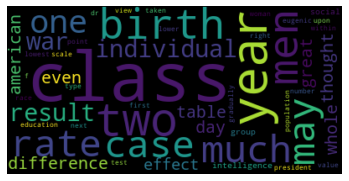

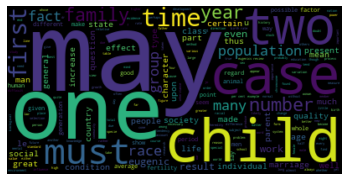

In [63]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

def get_words(df):
    for token in get_tokens(df):
        for word in token:
            yield word

topics = model[1].print_topics(num_words=50)
topics = topics[0][1].split('+')

topic_dict = {}
for topic in topics:
    word = topic.split('*')
    freq = float(word[0].strip())
    word = word[1].strip().strip('"')
    if word not in topic_dict.keys():
        topic_dict[word] = int(freq * 1000)
    else:
        topic_dict[word] += int(freq *1000)
        
text = " ".join([(k + " ")*v for k,v in topic_dict.items()])

text = text.replace("  ", " ")

wordcloud = WordCloud(collocations = False).generate(text)

_ = plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")
_ = plt.show()


text = " ".join(get_words(df[(df['year']>=1920) & (df['year']<1930)]))
wordcloud = WordCloud().generate(text)

_ = plt.imshow(wordcloud, interpolation='bilinear')
_ = plt.axis("off")
_ = plt.show()

